In [3]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-4
    @test norm(Bₖ*sₖ - yₖ) < 10e-4
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

SR1 (generic function with 2 methods)

In [4]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [117]:
function lineSearch(problem, x₀, Δ; affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    sₖ = zeros(n)
    yₖ = zeros(n)
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    B = problem.Hess(x₀)
    NormP = []
    F = [] 
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ)
            dₖ = -Hₖ*gₖ # Direction de descente
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = dₖ
            ### Calcul de la perte d'orthogonalité
            U = P'*B*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = i:(k+1)
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))  
        else
            dₖ = -gₖ # Direction de descente
            global P = dₖ
        end 
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G, orthogo)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G, orthogo)
end

lineSearch (generic function with 1 method)

In [121]:
function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    n = length(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    normP = []
    F = []
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = pₖ   
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = i:(k+1)
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = pₖ
        end
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= ϵ && negCurvature)
            if(dot(rₖ, pₖ) < ϵ)
                αₖ = 2*Δ/norm(pₖ) # On force à sortir de la région de confiance
            else
                αₖ = -2*Δ/norm(pₖ)
            end
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, norm(αₖ))
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G, orthogo)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k-1, normP, F, α, G, orthogo)
end

CG (generic function with 1 method)

In [115]:
using LinearOperators

function LMlineSearch(problem, x₀, Δ; mem = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    yₖ = zeros(n)
    sₖ = zeros(n)
    B = problem.Hess(x₀)
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    Hₖ = InverseLBFGSOperator(n, mem, scaling = false)
    A = problem.Hess(x₀)
    NormP = []
    F = []
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        dₖ = -Hₖ*gₖ # Direction de descente
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = dₖ
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = i:(k+1)
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = dₖ
        end
        bₖ = g(dₖ) - b
        if(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        ρₖ = 1/dot(sₖ, yₖ)
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        # Mise à jour de la liste des yₖ et sₖ
        push!(Hₖ, sₖ, yₖ)
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ) 
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G, orthogo)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G, orthogo)
end

LMlineSearch (generic function with 1 method)

In [82]:
N = 6
# d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
# d = [3, 4, 10, 3, 2, 10]
# d = [3, 10, 7, 2, 5, 9]
# d = [1, 1, 1, 1, 1, 1]
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement (décrochage de SR1)
# d = [10e-5, 8, 4e3, 3e5, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-singulière avec gros contionemment (1) (décallage de CG)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-singulière avec gros contionemment (2) (décrochage de BFGS)
# d = [0.015, 3.5, -0.15, -0.25, 0.95, 111.5] # Exemple où la norme de p n'est pas croissante
# d = [0.015, 3.5, 15, 25, 0.0095, -111.5] # Exemple où l'erreur de ||Bₖ - B|| pour BFGS augmente avec SR1
# d = [-0.015, 3.5, -15, 25, -0.0095, 111.5] # Exemple où BFGS meilleur que SR1
# d = [-0.015, 3.5, 15, 25, -0.0095, 111.5] # Exemple où SR1 produit une direction ascendante à la fin (avec negCurvature = false)
# d = [3000, -4000, -3000, -0.250, 0.25, 4000] # Yoyo
N, d = 6, [-1, 0.9, -0.8, 0.15, 3.1, 3] # SR1 : alpha > 0 alors que courbure négative
N, d = 15, [10, 9, 8, 0.35, 3.5, 3, 2, 1, 13, 20, 4.4, 7, 2.9, 0.1, 1.2]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
eigvals(D)
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

318.6521643269367

In [124]:
N = 100
d = rand(N)
u = -rand(N-1)
A = Tridiagonal(u, d, u) + 2*I
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

135.01979857624357

In [149]:
N = 300
A = rand(-50:0.001:50, N, N)
A = A'*A
b = rand(-30:0.001:30, N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))
println(norm(A)*norm(inv(A)))

[0.0502348, 13.605, 37.294, 71.8191, 98.7533, 135.176, 218.776, 329.105, 386.312, 435.327, 622.113, 724.127, 1088.18, 1166.2, 1425.47, 1537.54, 1822.5, 2028.87, 2208.18, 2388.13, 2662.22, 2918.84, 3323.02, 3424.11, 3910.13, 4303.62, 4824.51, 5038.29, 5650.29, 5758.59, 6064.65, 6906.59, 7203.95, 8112.39, 8751.51, 8957.87, 9668.85, 9855.94, 10920.6, 11173.7, 11567.7, 11990.3, 12514.3, 12790.4, 13825.6, 14228.2, 15403.3, 15591.4, 16394.9, 16768.1, 17463.1, 17971.6, 18664.9, 19172.9, 19880.7, 20783.6, 21115.3, 22480.7, 22881.3, 24121.0, 24162.5, 25766.8, 26320.5, 27126.4, 28667.2, 29272.3, 29816.1, 30558.9, 31619.8, 34520.8, 35359.2, 36473.0, 37300.3, 37638.8, 39565.3, 40123.7, 40849.1, 42312.0, 43781.7, 45218.2, 46568.0, 47758.6, 48936.3, 49595.1, 50757.5, 52398.0, 53988.5, 54331.9, 56647.0, 57428.9, 58426.5, 59239.6, 60761.2, 61540.8, 62093.8, 62170.4, 65107.0, 66703.7, 68066.2, 69570.2, 70559.9, 72205.3, 72710.0, 74446.9, 76911.1, 78489.8, 78868.5, 81361.2, 82241.4, 84916.9, 85968.3, 87

In [150]:
nC = false
Δ = Inf
aff = false
itmax = 2*N
pres = 10e-8

println("Méthode L-BFGS (mem = 1)")
@time p₁, NormP₁, iter₁, F₁, α₁, G₁, orthogo₁ = LMlineSearch(quadratic, x₀, Δ, mem = 1, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 30%)")
@time p₄, NormP₄, iter₄, F₄, α₄, G₄, orthogo₄ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.30*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 60%)")
@time p₃, NormP₃, iter₃, F₃, α₃, G₃, orthogo₃ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.60*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 70%)")
@time p, NormP, iter, F, α, G, orthogo = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.70*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 80%)")
@time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.80*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 90%)")
@time p₅, NormP₅, iter₅, F₅, α₅, G₅, orthogo₅ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.90*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 95%)")
@time p₇, NormP₇, iter₇, F₇, α₇, G₇, orthogo₇ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.95*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode BFGS")
@time p₂, NormP₂, iter₂, F₂, α₂, G₂, orthogo₂ = lineSearch(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff); 

println("Méthode L-BFGS (mem = 100%)")
@time p₈, NormP₈, iter₈, F₈, α₈, G₈, orthogo₈ = LMlineSearch(quadratic, x₀, Δ, mem = N, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode du GC")
@time pᵧ, iterᵧ, NormPᵧ, Fᵧ, αᵧ, Gᵧ, orthogoᵧ = CG(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, negCurvature = nC, affichage = aff)

println("")
@printf("%22s %8.1e \n","(BFGS)              ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
@printf("%22s %8.1e \n","(CG)                ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
@printf("%22s %8.1e \n","(L-BFGS mem = 1)    ||g(x₀ + p)|| = ", norm(g(x₀ + p₁)))
@printf("%22s %8.1e \n","(L-BFGS mem = 30%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₄)))
@printf("%22s %8.1e \n","(L-BFGS mem = 60%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₃)))
@printf("%22s %8.1e \n","(L-BFGS mem = 70%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(L-BFGS mem = 80%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₆)))
@printf("%22s %8.1e \n","(L-BFGS mem = 90%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₅)))
@printf("%22s %8.1e \n","(L-BFGS mem = 95%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₇)))
@printf("%22s %8.1e \n","(L-BFGS mem = 100%) ||g(x₀ + p)|| = ", norm(g(x₀ + p₈)))


Méthode L-BFGS (mem = 1)
  6.466439 seconds (2.47 M allocations: 3.589 GiB, 8.49% gc time)
Méthode L-BFGS (mem = 30%)
  5.974687 seconds (3.29 M allocations: 4.768 GiB, 9.52% gc time)
Méthode L-BFGS (mem = 60%)
  6.345849 seconds (4.04 M allocations: 5.773 GiB, 10.31% gc time)
Méthode L-BFGS (mem = 70%)
  6.206702 seconds (4.26 M allocations: 6.064 GiB, 10.60% gc time)
Méthode L-BFGS (mem = 80%)
  6.486091 seconds (4.46 M allocations: 6.334 GiB, 10.67% gc time)
Méthode L-BFGS (mem = 90%)
  6.556406 seconds (4.65 M allocations: 6.583 GiB, 12.00% gc time)
Méthode L-BFGS (mem = 95%)
  6.427470 seconds (4.74 M allocations: 6.699 GiB, 10.89% gc time)
Méthode BFGS
  3.538534 seconds (46.38 k allocations: 4.383 GiB, 8.34% gc time)
Méthode L-BFGS (mem = 100%)
  1.201063 seconds (834.84 k allocations: 1.638 GiB, 8.74% gc time)
Méthode du GC
  5.746371 seconds (2.38 M allocations: 3.563 GiB, 8.59% gc time)

(BFGS)              ||g(x₀ + p)|| =   1.4e-08 
(CG)                ||g(x₀ + p)|| =   3.0e

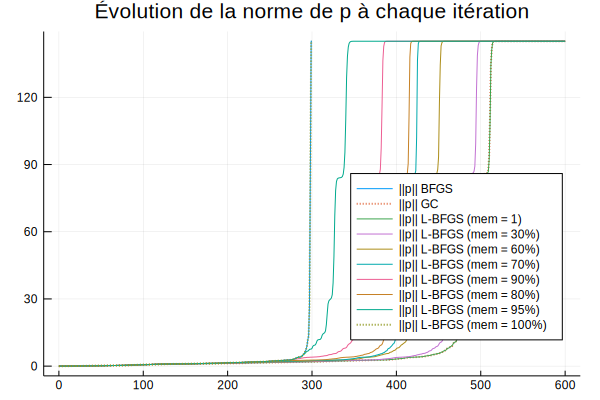

In [151]:
plot(0:iter₂, NormP₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), NormPᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:iter₁, NormP₁, label = "||p|| L-BFGS (mem = 1)")
plot!(0:iter₄, NormP₄, label = "||p|| L-BFGS (mem = 30%)")
plot!(0:iter₃, NormP₃, label = "||p|| L-BFGS (mem = 60%)")
plot!(0:iter, NormP, label = "||p|| L-BFGS (mem = 70%)", title = "Évolution de la norme de p à chaque itération", legend = :bottomright)
plot!(0:iter₅, NormP₅, label = "||p|| L-BFGS (mem = 90%)")
plot!(0:iter₆, NormP₆, label = "||p|| L-BFGS (mem = 80%)")
plot!(0:iter₇, NormP₇, label = "||p|| L-BFGS (mem = 95%)")
plot!(0:iter₈, NormP₈, label = "||p|| L-BFGS (mem = 100%)", line = :dot, lw = 2)

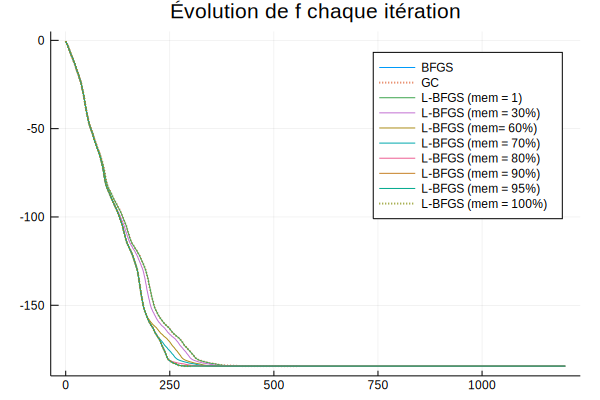

In [137]:
plot(0:iter₂, F₂, label = "BFGS")
plot!(0:(iterᵧ), Fᵧ, label = "GC", lw = 2, line = :dot)
plot!(0:iter₁, F₁, label = "L-BFGS (mem = 1)")
plot!(0:iter₄, F₄, label = "L-BFGS (mem = 30%)")
plot!(0:iter₃, F₃, label = "L-BFGS (mem= 60%)")
plot!(0:iter, F, label = "L-BFGS (mem = 70%)", title = "Évolution de f chaque itération")
plot!(0:iter₆, F₆, label = "L-BFGS (mem = 80%)")
plot!(0:iter₅, F₅, label = "L-BFGS (mem = 90%)")
plot!(0:iter₇, F₇, label = "L-BFGS (mem = 95%)")
plot!(0:iter₈, F₈, label = "L-BFGS (mem = 100%)", lw = 2, line = :dot)

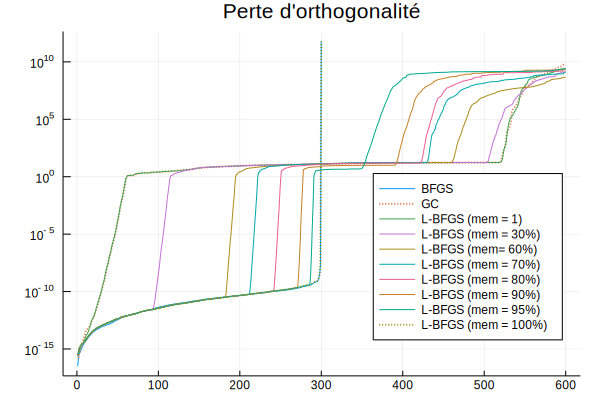

In [152]:
plot(1:iter₂, orthogo₂, label = "BFGS", title = "Perte d'orthogonalité", yaxis = :log, legend = :bottomright)
plot!(1:(iterᵧ), orthogoᵧ, label = "GC", lw = 2, line = :dot)
plot!(1:iter₁, orthogo₁, label = "L-BFGS (mem = 1)")
plot!(1:iter₄, orthogo₄, label = "L-BFGS (mem = 30%)")
plot!(1:iter₃, orthogo₃, label = "L-BFGS (mem= 60%)")
plot!(1:iter, orthogo, label = "L-BFGS (mem = 70%)")
plot!(1:iter₆, orthogo₆, label = "L-BFGS (mem = 80%)")
plot!(1:iter₅, orthogo₅, label = "L-BFGS (mem = 90%)")
plot!(1:iter₇, orthogo₇, label = "L-BFGS (mem = 95%)")
plot!(1:iter₈, orthogo₈, label = "L-BFGS (mem = 100%)", lw = 2, line = :dot)

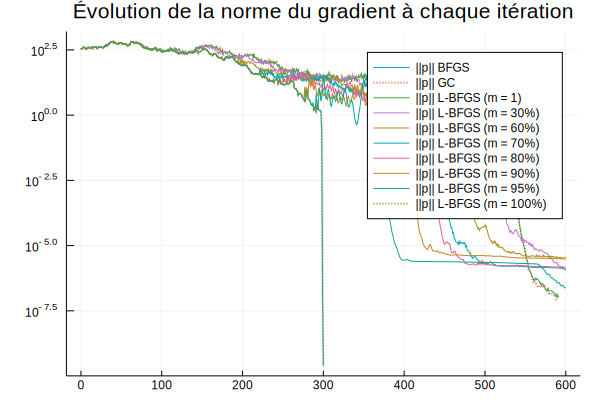

In [147]:
plot(0:(iter₂), G₂, label = "||p|| BFGS", title = "Évolution de la norme du gradient à chaque itération", yaxis = :log) #, legend = :bottomleft)
plot!(0:(iterᵧ), Gᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:(iter₁), G₁, label = "||p|| L-BFGS (m = 1)")
plot!(0:(iter₄), G₄, label = "||p|| L-BFGS (m = 30%)")
plot!(0:(iter₃), G₃, label = "||p|| L-BFGS (m = 60%)")
plot!(0:(iter), G, label = "||p|| L-BFGS (m = 70%)")
plot!(0:(iter₆), G₆, label = "||p|| L-BFGS (m = 80%)")
plot!(0:(iter₅), G₅, label = "||p|| L-BFGS (m = 90%)")
plot!(0:(iter₇), G₇, label = "||p|| L-BFGS (m = 95%)")
plot!(0:(iter₈), G₈, label = "||p|| L-BFGS (m = 100%)", lw = 2, line = :dot)

In [70]:
# Conditionnement
norm(A)*norm(inv(A))

1.9948332991117086e7

In [148]:
iter₂

300